Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
!pwd

/content


In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive

'Colab Notebooks'  'Skin cancer ISIC The International Skin Imaging Collaboration'


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Create test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Do not shuffle test data
)

Found 118 files belonging to 9 classes.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

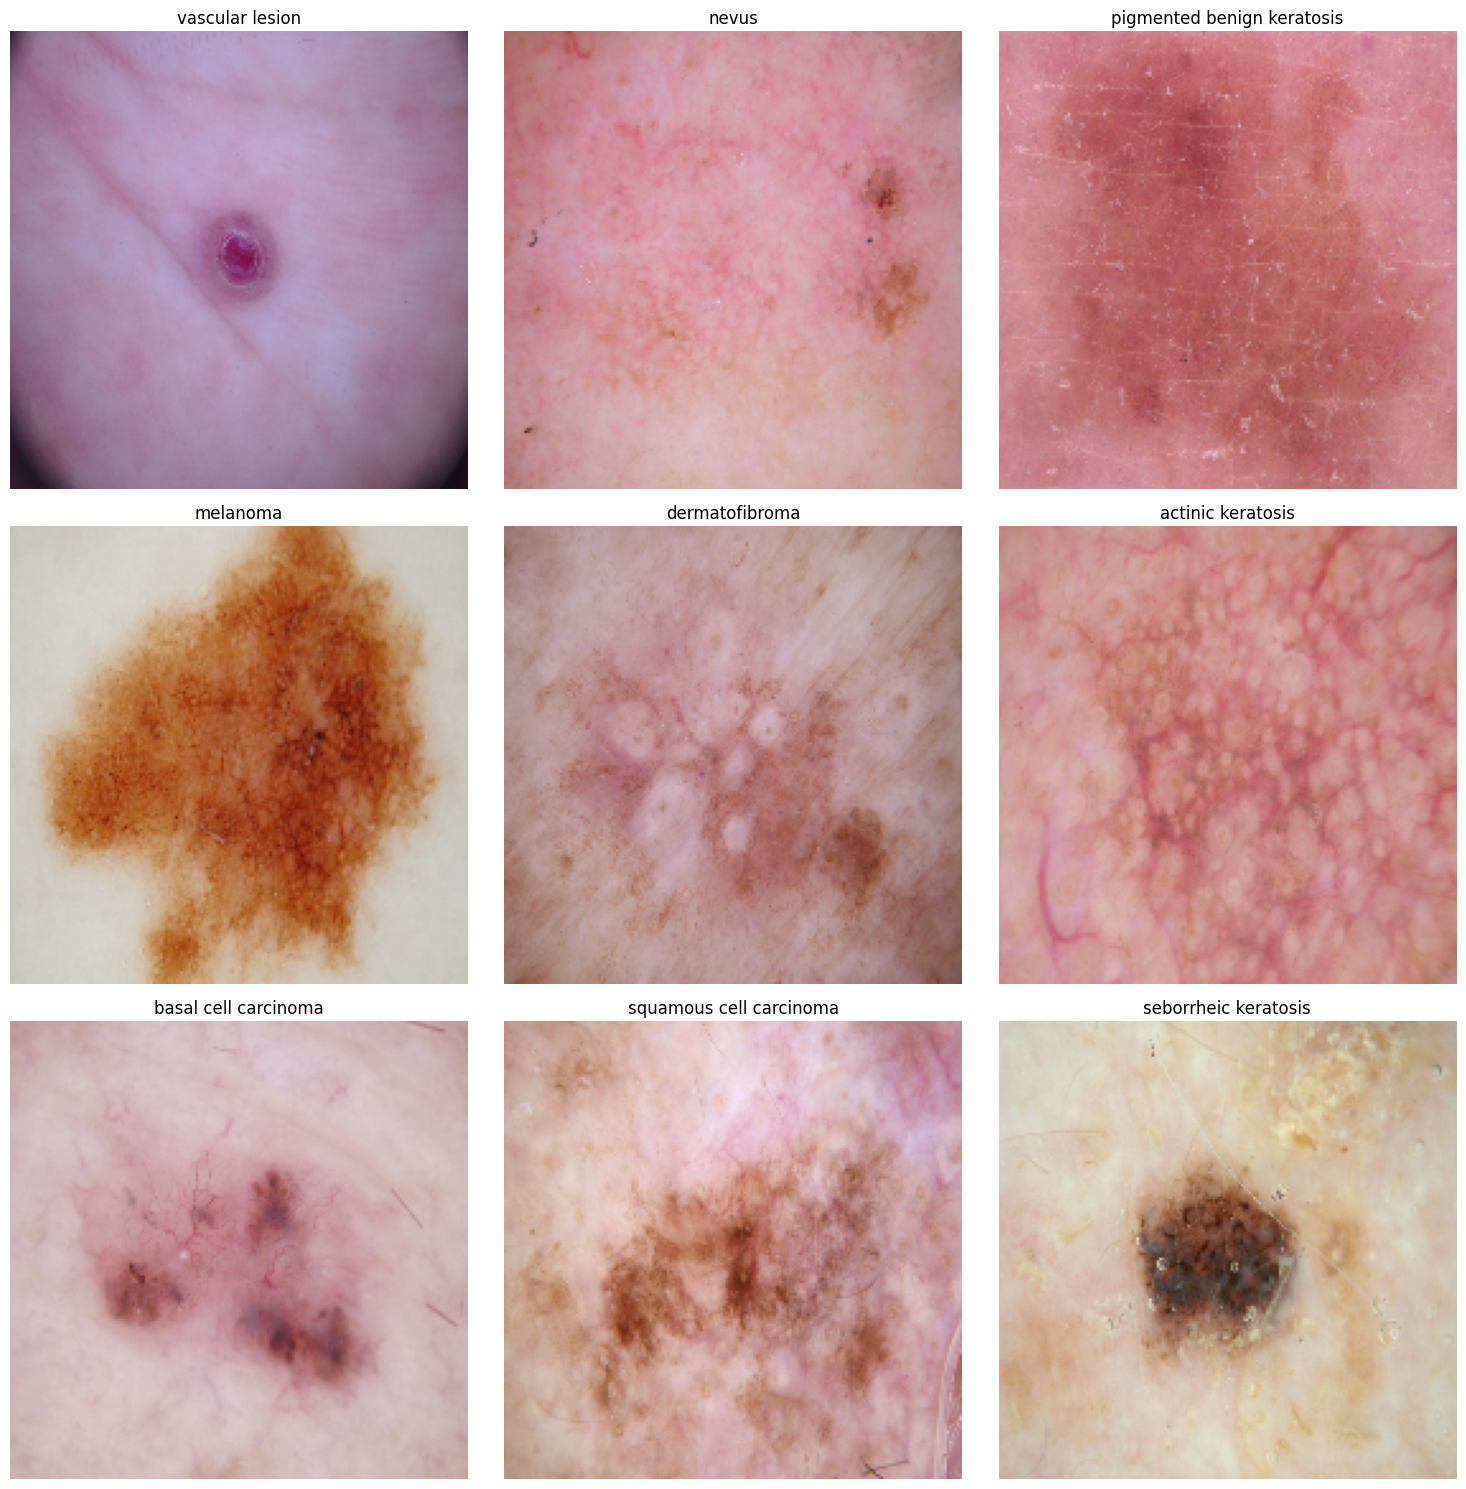

In [12]:

### your code goes here, you can use training or validation data to visualize
import tensorflow as tf
import matplotlib.pyplot as plt

def collect_one_image_per_class(dataset):
    class_images = {}
    class_names = dataset.class_names

    # Iterate through the dataset to collect one image per class
    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_name = class_names[label.numpy()]
            if class_name not in class_images:
                class_images[class_name] = img
            if len(class_images) == len(class_names):
                return class_images  # Return early if all classes are collected
    return class_images

def plot_images_per_class(class_images):
    num_classes = len(class_images)
    plt.figure(figsize=(15, 15))

    for i, (class_name, image) in enumerate(class_images.items()):
        plt.subplot(3, 3, i + 1)  # Adjust grid size for 9 images
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Replace 'train_dataset' with the appropriate dataset variable
# Collect one image per class from the dataset
class_images = collect_one_image_per_class(train_ds)

# Visualize the collected images
plot_images_per_class(class_images)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')  # Adjust for your number of classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,010,377 (42.00 MB)

 Trainable params: 11,010,377 (42.00 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 778ms/step - accuracy: 0.2795 - loss: 1.8728 - val_accuracy: 0.3400 - val_loss: 1.8596
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.4074 - loss: 1.6212 - val_accuracy: 0.4631 - val_loss: 1.4957
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4988 - loss: 1.4572 - val_accuracy: 0.5145 - val_loss: 1.4709
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4909 - loss: 1.4549 - val_accuracy: 0.5145 - val_loss: 1.4553
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5190 - loss: 1.3850 - val_accuracy: 0.5391 - val_loss: 1.4036
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5497 - loss: 1.3117 - val_accuracy: 0.5011 - val_loss: 1.4390
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5352 - loss: 1.2887 - val_accuracy: 0.4743 - val_loss: 1.5013
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5401 - loss: 1.2955 - val_accuracy: 0.5213 

### Visualizing training results

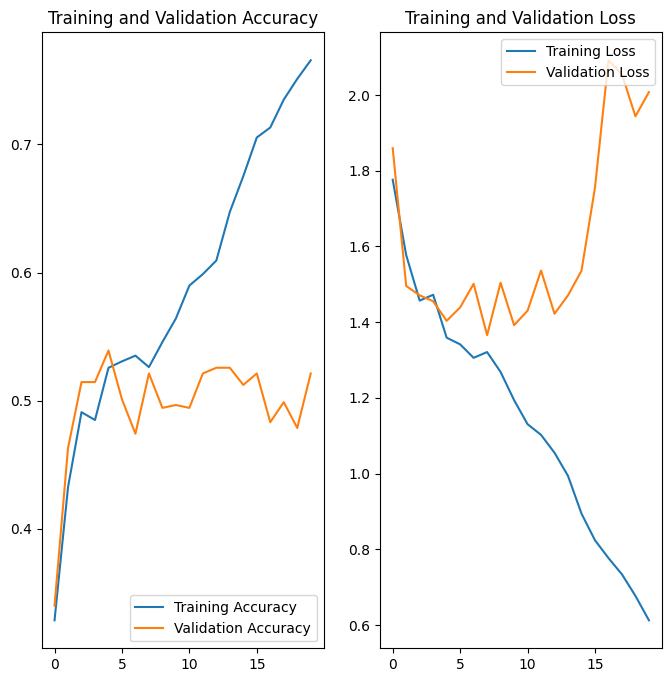

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# # Normalize pixel values to [0, 1] using Rescaling
# normalization_layer = layers.Rescaling(1./255)

# def preprocess_test_dataset(dataset):
#     dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
#     dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#     return dataset

# # Apply preprocessing to the test dataset
# test_ds = preprocess_test_dataset(test_dataset)

# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(test_ds)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here


After training the model:
*  accuracy: 78%
*  validation accuracy: 52%


---


This means the model is overfitting,performing well on train data and not well on new data










In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


# Apply data augmentation and normalization to the training dataset
def augment_and_normalize(image, label):
    image = data_augmentation(image)
    return image, label

# Apply augmentation and normalization to the training dataset
train_ds = train_ds.map(augment_and_normalize)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the CNN model
model = Sequential([

    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')  # Adjust number of units to match number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.2366 - loss: 2.0237 - val_accuracy: 0.4295 - val_loss: 1.6278
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3950 - loss: 1.6823 - val_accuracy: 0.4474 - val_loss: 1.5783
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4421 - loss: 1.5477 - val_accuracy: 0.4743 - val_loss: 1.4921
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4783 - loss: 1.4891 - val_accuracy: 0.4765 - val_loss: 1.5360
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4971 - loss: 1.4188 - val_accuracy: 0.5034 - val_loss: 1.4253
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5263 - loss: 1.3356 - val_accuracy: 0.4787 - val_loss: 1.4750
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5234 - loss: 1.3066 - val_accuracy: 0.5369 - val_loss: 1.4409
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5403 - loss: 1.2424 - val_accuracy: 0.5213 - 

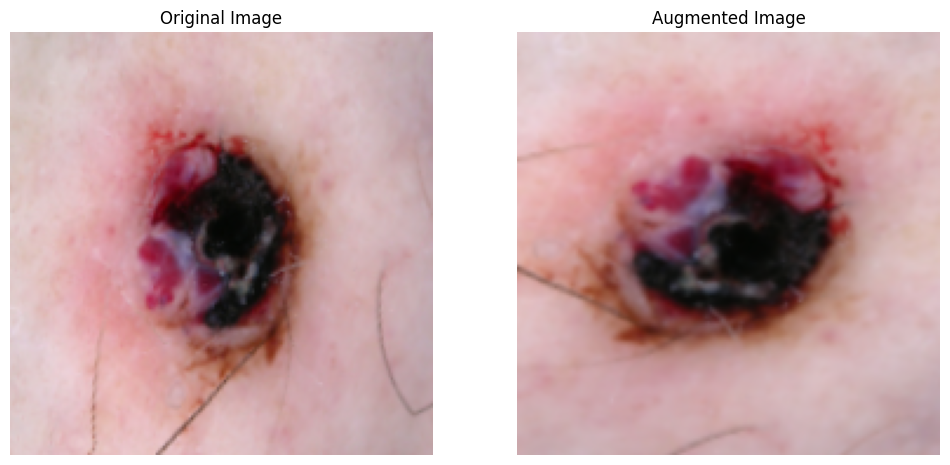

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import tensorflow as tf
import matplotlib.pyplot as plt

# Define the data augmentation pipeline (same as your training augmentation)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# Load a sample image from the dataset
def load_sample_image(dataset):
    for image, _ in dataset.take(1):
        return image[0]  # Return the first image from the batch

# Assuming train_ds is your dataset, load a sample image
sample_image = load_sample_image(train_ds)


# Apply data augmentation to the sample image
augmented_image = data_augmentation(sample_image)

# Plot the original and augmented images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image.numpy()/255)
plt.axis('off')

# Augmented image
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_image.numpy()/255)
plt.axis('off')

plt.show()




### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here


# Define the CNN model with Dropout layers
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),  # Dropout before the final output layer
    layers.Dense(9, activation='softmax')  # Adjust number of units to match number of classes
])





### Compiling the model

In [23]:
## Your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1804 - loss: 2.3026 - val_accuracy: 0.2058 - val_loss: 2.0871
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2136 - loss: 2.0024 - val_accuracy: 0.2282 - val_loss: 2.0540
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2501 - loss: 1.9622 - val_accuracy: 0.2595 - val_loss: 1.9735
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2726 - loss: 1.9212 - val_accuracy: 0.3132 - val_loss: 1.8656
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3167 - loss: 1.8464 - val_accuracy: 0.3848 - val_loss: 1.7109
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3982 - loss: 1.6848 - val_accuracy: 0.4474 - val_loss: 1.5530
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4765 - loss: 1.4727 - val_accuracy: 0.4966 - val_loss: 1.4739
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4929 - loss: 1.4512 - val_accuracy: 0.2908 - v

### Visualizing the results

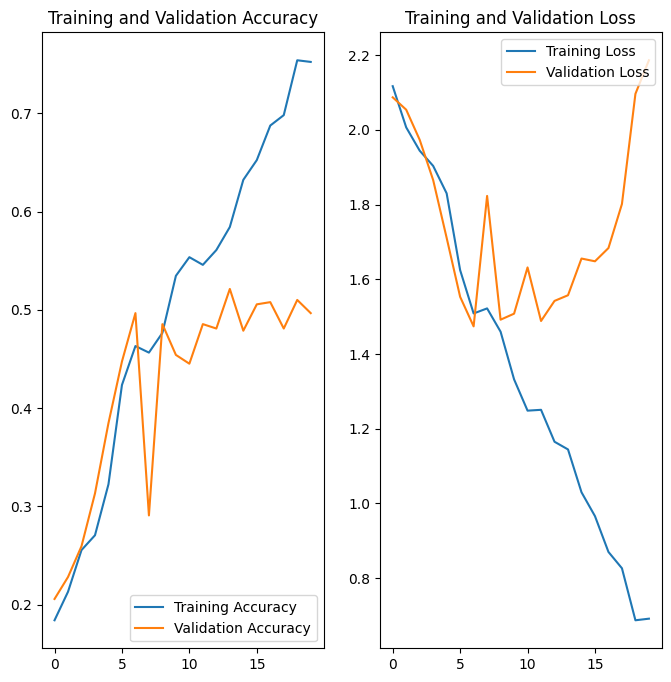

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After using augmentation and dropouts,still the model is overfitting because training accuracy is high compared to validation accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
from collections import Counter

# Function to count class occurrences
def count_classes(dataset):
    class_counts = Counter()
    for _, labels in dataset:
        class_counts.update(labels.numpy())
    return class_counts

# Get class counts from the training dataset
class_counts = count_classes(train_ds)

# Print the class distribution
for class_label, count in class_counts.items():
    print(f'Class {class_label}: {count} samples')

Class 1: 309 samples
Class 7: 142 samples
Class 3: 352 samples
Class 5: 370 samples
Class 4: 277 samples
Class 2: 77 samples
Class 0: 92 samples
Class 6: 58 samples
Class 8: 115 samples


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Class with the Least Number of Samples:

1. Class 6 has the least number of samples with 58.


---


Classes Dominating the Data:


1.   Class 5 has the highest number of samples with 370.
2.   Class 3 follows with 352 samples.
3.   Class 1 also has a relatively high number of samples with 309






#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:

path_to_training_dataset=pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

import Augmentor
for i in class_names:
    class_path = path_to_training_dataset / i

    # Initialize the Augmentor pipeline for the class
    p = Augmentor.Pipeline(str(class_path))  # Convert Path object to string

    # p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBA4E4420B0>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DBA4E3C7B50>: 100%|██████████| 500/500 [00:17<00:00, 28.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBA4E545E70>: 100%|██████████| 500/500 [00:17<00:00, 27.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DBA4E207010>: 100%|██████████| 500/500 [01:12<00:00,  6.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBA4E22F280>: 100%|██████████| 500/500 [01:08<00:00,  7.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DBA4E3962C0>: 100%|██████████| 500/500 [00:19<00:00, 25.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DBA4E23A770>: 100%|██████████| 500/500 [00:37<00:00, 13.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBAB021FD30>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBA4E545DE0>: 100%|██████████| 500/500 [00:17<00:00, 28.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024948.jpg_f4996875-ad7b-4afa-baa9-41fb928f4417.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000477.jpg_e0f990ba-9376-425e-b448-4fc702265a6f.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000483.jpg_5f3f3d9c-0e7c-4d38-9ace-534ae8630886.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000020.jpg_974a04c5-85b6-407e-b65f-e3cb2ad1ca69.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000256.jpg_a52ed207-56ed-448c-b273-d3145f3ca31e.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ne

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df['Label'].value_counts()

Label
nevus                         500
squamous cell carcinoma       500
vascular lesion               500
basal cell carcinoma          500
actinic keratosis             500
melanoma                      500
pigmented benign keratosis    500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train=pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")


train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu'),
     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    layers.Conv2D(64, (3, 3), activation='relu'),
     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    layers.Conv2D(128, (3, 3), activation='relu'),
     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    layers.Conv2D(256, (3, 3), activation='relu'),
     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout after pooling

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),  # Dropout before the final output layer
    layers.Dense(9, activation='softmax')  # Adjust number of units to match number of classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 69s 340ms/step - accuracy: 0.2896 - loss: 8.2281 - val_accuracy: 0.1722 - val_loss: 3.7640
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 239ms/step - accuracy: 0.4437 - loss: 1.5901 - val_accuracy: 0.1938 - val_loss: 5.8081
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.5298 - loss: 1.3678 - val_accuracy: 0.3482 - val_loss: 2.8886
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 248ms/step - accuracy: 0.5970 - loss: 1.1401 - val_accuracy: 0.3883 - val_loss: 2.8693
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 237ms/step - accuracy: 0.6531 - loss: 0.9923 - val_accuracy: 0.6526 - val_loss: 0.9623
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - accuracy: 0.7060 - loss: 0.8027 - val_accuracy: 0.6659 - val_loss: 0.9428
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.7340 - loss: 0.7333 - val_accuracy: 0.6704 - val_loss: 0.9756
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 235ms/step - accuracy: 0.7645 - loss: 0

#### **Todo:**  Visualize the model results

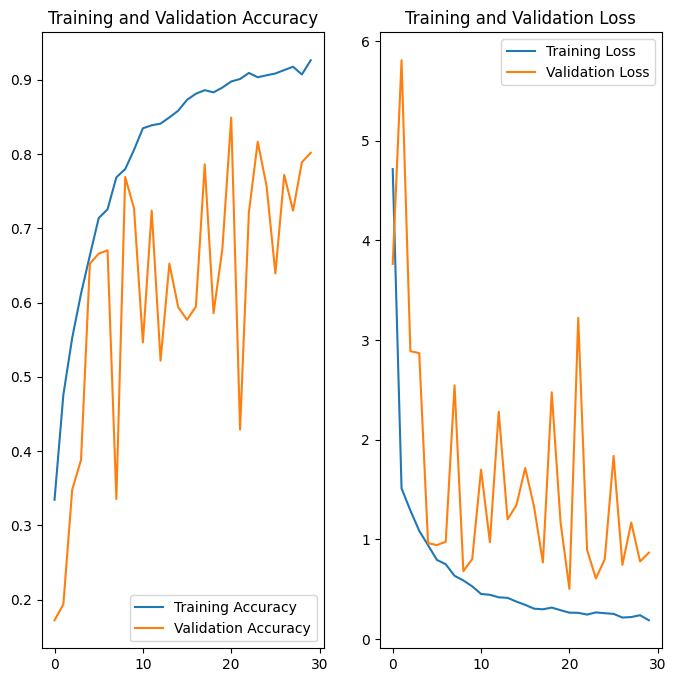

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
test_ds = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.3390 - loss: 4.6931


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



After class rebalancing:
- accuracy: 0.9236
- val_accuracy: 0.8018

which have near values in accuracy.

But on test data,still accuracy is low. Might need more data to build the model for more accuracy.